# Interpreting hyperspectral tabluar data with SHAP: HYPERVIEW Challenge


This notebook demonstrates the usability of the explanations with shapley values (SHAP) to interpret the predictions of a hyperspectral image regression model. The dataset used in this notebook is from the [HYPERVIEW Challenge](https://platform.ai4eo.eu/seeing-beyond-the-visible-permanent) organized by KP Labs and European Space Agency (ESA). The goal of the challenge is to predict `4` soil parameters based on the airborne hyperspectral images.

The analysed model is Random Forest, which is the top-performing model from the HYPERVIEW Challenge. It works on the carefully preprocessed dataframe, created from  the input hyperspectral images. In short, the preprocessing pipeline applies several transformations to the reflectance values, such as averaging the reflectance values, applying the Fast Fourier Transformation or discrete wavelet transform. The description of the preprocessing steps can be found [here](https://github.com/ridvansalihkuzu/hyperview_eagleeyes/blob/master/challenge_submission_eagleeyes/hyperview-main-submission_eagleeyes.ipynb).

The trained model architecture is based on the Vision Transformer (ViT) and CLIP (Contrastive Language-Image Pretraining), and its fine-tuned weights are open-sourced under the Apache License in the [Hugging Face Model Hub](https://huggingface.co/KPLabs/HYPERVIEW-VisionTransformer). In the same place, the original implementation of the CLIP model can be found. 

**Note**: Before running this notebook, make sure to install the required libraries used in the notebook. It should be sufficient to install the package `meteors` from PyPI, as it carry all the required dependencies.


Missing dependencies:
```
pip install PyWavelets
```


## Table of Contents


## Data loading


Here, to make this tutorial executable, we skip calculation of the explanations for the whole HYPERVIEW dataset. Analysis of this kind of explanations can be found in the paper published by us: Red Teaming Models for Hyperspectral Image Analysis Using Explainable AI.

To analyze the EagleEyes model, we firstly need to apply the preprocessing, as described  [here](https://huggingface.co/KPLabs/HYPERVIEW-RandomForest).



In [1]:
import meteors as mt
import matplotlib.pyplot as plt
import os
import joblib

In [2]:
from typing import List, Tuple
from pathlib import Path
from eagleeyes import preprocess, download
import pandas as pd


def load_data() -> Tuple[List, pd.DataFrame]:
    base_path = Path("data")
    X_train = list(base_path.glob("*.npz"))
    y_train = pd.read_csv(base_path / "train_gt.csv", index_col="sample_index")

    return X_train, y_train


samples_list, y_train = load_data()

assert len(samples_list) == 10, len(y_train) == 10

Now let's apply the preprocessing that was the key to winning the HYPERVIEW Challenge!

In [3]:
features: List[str] = ["fft", "dwt", "gradient", "mean"]

X_train, column_transformations = preprocess(samples_list, features)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 25.21it/s]


In [4]:
samples_list[0].shape

(1200,)

## Model preparation
To showcase the library usage we will temporarily use the dummy model

In [5]:
download_root = os.path.expanduser("~/.cache/eagleeyes")
num_classes = 4

In [9]:
rf_checkpoint_path = download(
    "https://huggingface.co/KPLabs/HYPERVIEW-RandomForest/resolve/main/RF_model_150_bands.joblib",
    download_root,
    error_checksum=False,
)

INFO: Real SHA256: f9167332bd4d87b6f8b863e53f9fc38e19d70c175ea8d4fb14df8ec676484684


In [10]:
# monkey patching for sklearn - this is a workaround for a non-compatible version of the model

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Patch the class itself before unpickling
if not hasattr(DecisionTreeRegressor, 'monotonic_cst'):
    DecisionTreeRegressor.monotonic_cst = None
    
if not hasattr(RandomForestRegressor, 'monotonic_cst'):
    RandomForestRegressor.monotonic_cst = None

model = joblib.load(rf_checkpoint_path)

/mnt/evafs/groups/mi2lab/tkwiecinski/scripts/miniconda3/envs/sar/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/evafs/groups/mi2lab/tkwiecinski/scripts/miniconda3/envs/sar/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## SHAP Explanations 


% here some text about the shapley values, how they work etc.



To initialize the `HyperSHAP` object, we need to 

In [12]:
model.predict(X_train)

array([[ 57.471 , 208.45  , 157.1   ,   6.8339],
       [ 73.382 , 209.74  , 159.228 ,   6.9983],
       [ 54.887 , 201.33  , 169.096 ,   6.801 ],
       [103.86  , 319.49  , 193.57  ,   6.8817],
       [ 55.686 , 216.2   , 166.399 ,   6.7572],
       [ 73.017 , 219.32  , 168.422 ,   7.116 ],
       [ 61.844 , 254.71  , 143.72  ,   6.647 ],
       [ 53.305 , 214.23  , 150.768 ,   6.8442],
       [ 69.188 , 204.25  , 147.264 ,   6.9239],
       [ 69.304 , 214.95  , 160.682 ,   6.9949]])

In [11]:
with open("data/wavelenghts.txt", "r") as f:
    wavelengths = f.readline()
wavelengths = [float(wave.strip()) for wave in wavelengths.split(",")]

In [13]:
explainable_model = mt.models.ExplainableModel(model, "regression")

In [ ]:
explainer = mt.shap.HyperSHAP(explainable_model, masker = None)

In [17]:
explanation = explainer.explain(X_train)

We have sucessfully created the explanations! Now let us  visualize them using different methods and investigate what those mean!

Meteors package supports several plots:
    "force",
    "beeswarm",
    "dependence_plot",
    "waterfall",
    "heatmap",
    "bar",
    "wavelengths_bar",

In [23]:
model.predict(X_train)

array([[ 57.471 , 208.45  , 157.1   ,   6.8339],
       [ 73.382 , 209.74  , 159.228 ,   6.9983],
       [ 54.887 , 201.33  , 169.096 ,   6.801 ],
       [103.86  , 319.49  , 193.57  ,   6.8817],
       [ 55.686 , 216.2   , 166.399 ,   6.7572],
       [ 73.017 , 219.32  , 168.422 ,   7.116 ],
       [ 61.844 , 254.71  , 143.72  ,   6.647 ],
       [ 53.305 , 214.23  , 150.768 ,   6.8442],
       [ 69.188 , 204.25  , 147.264 ,   6.9239],
       [ 69.304 , 214.95  , 160.682 ,   6.9949]])

In [38]:
from meteors.visualize import force


force(explainer, explanation, target=1, observation_index=5, use_pyplot=True)

IndexError: index 5 is out of bounds for axis 0 with size 4

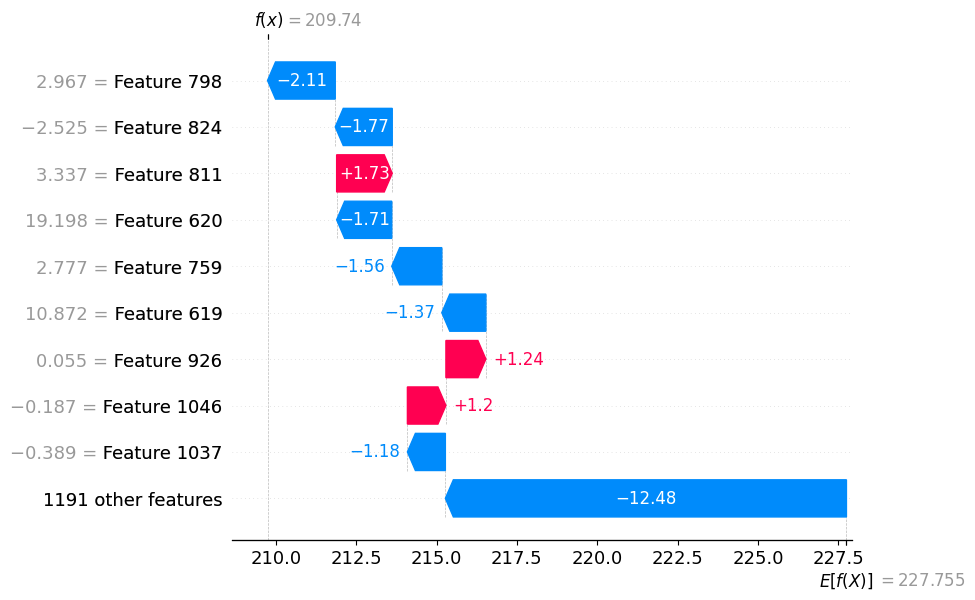

In [36]:
from meteors.visualize import waterfall

waterfall(explainer, explanation, target=1, observation_index=1, use_pyplot=True)

In [15]:
explanation.feature_names

In [16]:
from meteors.visualize import heatmap

heatmap(explainer, explanation, target=0)  # here we need to add some exeption wrapper

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

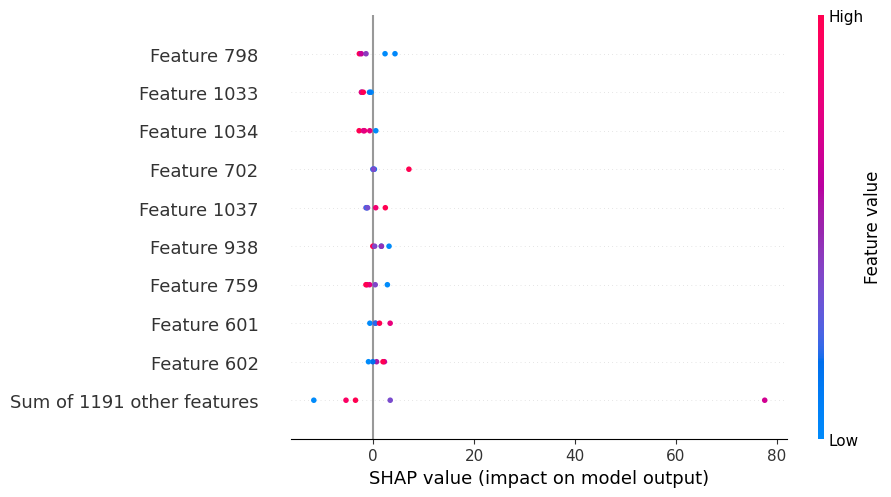

In [17]:
from meteors.visualize import beeswarm


beeswarm(explainer, explanation, target=1)
plt.show()

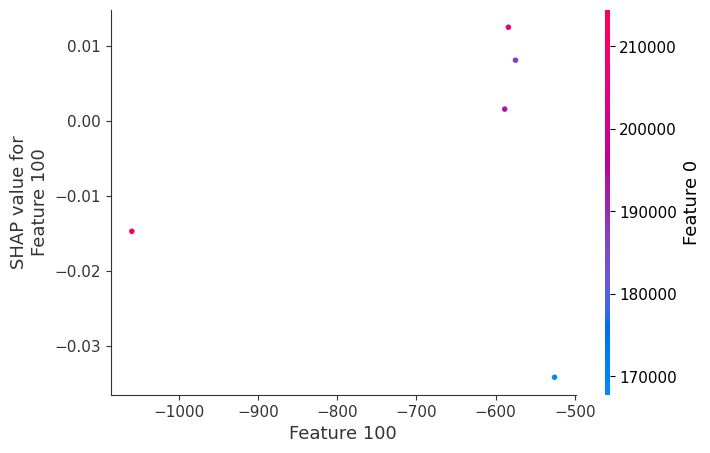

In [18]:
from meteors.visualize import dependence_plot

dependence_plot(100, explainer, explanation, target=1, use_pyplot=True)

this plot supports passing the feature index by hand, by default the feature taken to be displayed is the one with the highest correlation with the first one:

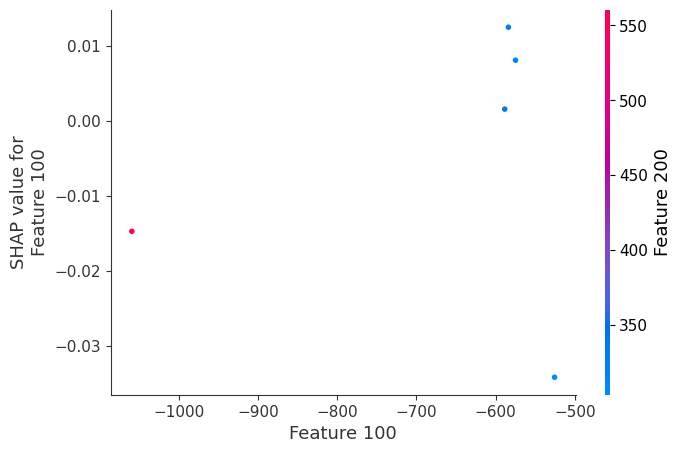

In [19]:
dependence_plot(100, explainer, explanation, target=1, use_pyplot=True, interaction_index=200)

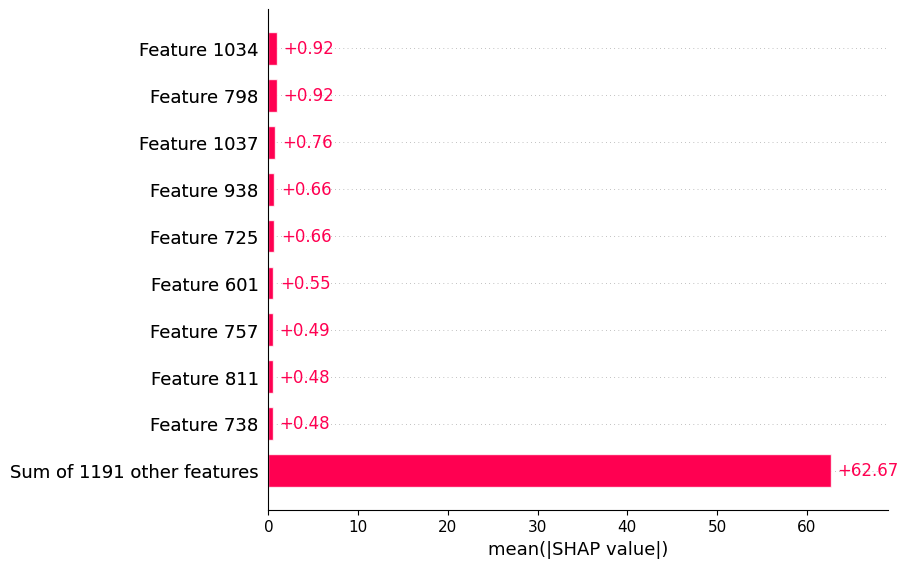

In [20]:
from meteors.visualize import bar


bar(explainer, explanation, target=2, use_pyplot=True)

Wavelengths bar plot:

In [21]:
wavelengths[10 % len(wavelengths)]

494.04

In [31]:
wavelengths_mapping = {str(wavelengths[i]): [150*j + i for j in range(8)] for i in range(len(wavelengths))}

In [32]:
wavelengths_mapping

{'462.08': [0, 150, 300, 450, 600, 750, 900, 1050],
 '465.27': [1, 151, 301, 451, 601, 751, 901, 1051],
 '468.47': [2, 152, 302, 452, 602, 752, 902, 1052],
 '471.67': [3, 153, 303, 453, 603, 753, 903, 1053],
 '474.86': [4, 154, 304, 454, 604, 754, 904, 1054],
 '478.06': [5, 155, 305, 455, 605, 755, 905, 1055],
 '481.26': [6, 156, 306, 456, 606, 756, 906, 1056],
 '484.45': [7, 157, 307, 457, 607, 757, 907, 1057],
 '487.65': [8, 158, 308, 458, 608, 758, 908, 1058],
 '490.85': [9, 159, 309, 459, 609, 759, 909, 1059],
 '494.04': [10, 160, 310, 460, 610, 760, 910, 1060],
 '497.24': [11, 161, 311, 461, 611, 761, 911, 1061],
 '500.43': [12, 162, 312, 462, 612, 762, 912, 1062],
 '503.63': [13, 163, 313, 463, 613, 763, 913, 1063],
 '506.83': [14, 164, 314, 464, 614, 764, 914, 1064],
 '510.03': [15, 165, 315, 465, 615, 765, 915, 1065],
 '513.22': [16, 166, 316, 466, 616, 766, 916, 1066],
 '516.42': [17, 167, 317, 467, 617, 767, 917, 1067],
 '519.61': [18, 168, 318, 468, 618, 768, 918, 1068],
 '5

In [34]:
features

['fft', 'dwt', 'gradient', 'mean']

In [ ]:
transformations_mapping = {features[i]: []

<Axes: title={'center': 'SHAP explanations for target 1'}, xlabel='Wavelengths (nm)', ylabel='mean(|SHAP value|)'>

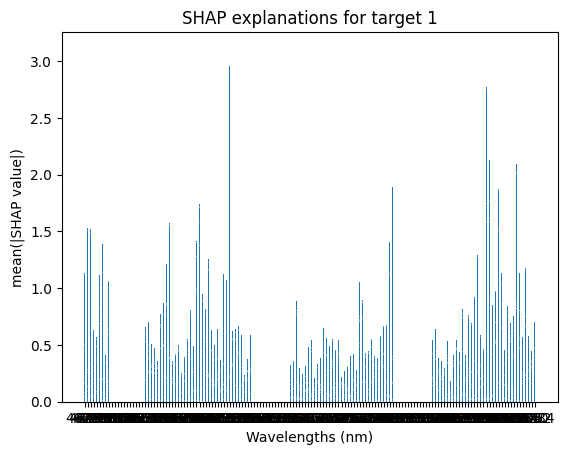

In [33]:
from meteors.visualize import wavelengths_bar

wavelengths_bar(explainer, explanation, target=1, wavelengths_mapping=wavelengths_mapping)